# Check science reply questions
Let's look at some data related to sharing new science articles and the questions that people pose in response to the articles.

We'll see how readily we can predict author background using the questions.

In [8]:
## get Reddit data!!
from datetime import datetime
from psaw import PushshiftAPI
from tqdm import tqdm
# from data_helpers import load_reddit_api
# reddit_api, pushshift_api = load_reddit_api('../../data/auth_data/reddit_auth.csv')
pushshift_api = PushshiftAPI()
date_range = ['2020-01-01', '2021-09-01']
date_range = list(map(lambda x: int(datetime.strptime(x, '%Y-%m-%d').timestamp()), date_range))
subreddit = 'science'
filter_fields = ['url', 'title', 'author', 'score', 'text', 'created_utc', 'id', 'upvote_ratio', 'num_comments']
submissions = pushshift_api.search_submissions(q="*", after=date_range[0], before=date_range[1],
                                               subreddit=subreddit, filter=filter_fields)
submissions_results = []
for s in tqdm(submissions):
    submissions_results.append(s)

0it [00:00, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
1001it [00:05, 286.60it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
47091it [07:52, 99.66it/s] 


In [14]:
## convert to data frame
import pandas as pd
submission_data = pd.DataFrame(submissions_results)
display(submission_data.head())

,author,created_utc,id,num_comments,score,title,upvote_ratio,url,created,d_
0,talismanbrandi,1630462648,pfkdt5,3,1,Socio-economic disparities and COVID-19 in the...,1.0,https://www.reddit.com/r/science/comments/pfkd...,1630480648.0,"{'author': 'talismanbrandi', 'created_utc': 16..."
1,BeforeYourBBQ,1630462436,pfkbn2,3,1,Comparing SARS-CoV-2 natural immunity to vacci...,1.0,https://www.medrxiv.org/content/10.1101/2021.0...,1630480436.0,"{'author': 'BeforeYourBBQ', 'created_utc': 163..."
2,key__lime_pie,1630462250,pfk9q9,2,1,Scientists Figured Out How Much Exercise You N...,1.0,https://www.sciencealert.com/scientists-figure...,1630480250.0,"{'author': 'key__lime_pie', 'created_utc': 163..."
3,key__lime_pie,1630462179,pfk90j,468,1,Female octopuses throw shells at males annoyin...,1.0,https://www.independent.co.uk/climate-change/n...,1630480179.0,"{'author': 'key__lime_pie', 'created_utc': 163..."
4,Doozenburg,1630461660,pfk3ts,2,1,Who is Anti-Vax Dr. Wendy Menigoz?,1.0,https://www.slugbrain.com/post/who-is-anti-vax...,1630479660.0,"{'author': 'Doozenburg', 'created_utc': 163046..."


Let's collect all comments from the same time frame, and align them to submissions afterward.

In [ ]:
date_range = ['2020-01-01', '2021-09-01']
date_range = list(map(lambda x: int(datetime.strptime(x, '%Y-%m-%d').timestamp()), date_range))
subreddit = 'science'
filter_fields = ['id', 'link_id', 'parent_id', 'body', 'author', 'created_utc', 'score']
comments = pushshift_api.search_comments(after=date_range[0], before=date_range[1],
                                         subreddit=subreddit, filter=filter_fields)
comments_results = []
for c in tqdm(comments):
    comments_results.append(c)

0it [00:00, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
901it [00:03, 289.96it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
18800it [03:16, 23.04it/s] /home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 502
  warnings.warn("Got non 200 code %s" % response.status_code)
907905it [2:33:53, 83.42it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending outp

In [34]:
## combine/clean
comment_data = pd.DataFrame(comments_results)
# drop deleted data
comment_data = comment_data[(comment_data.loc[:, 'author']!='[deleted]') &
                            (comment_data.loc[:, 'body']!='[deleted]')]
# fix ID vars
comment_data = comment_data.assign(**{
    'link_id' : comment_data.loc[:, 'link_id'].apply(lambda x: x.split('_')[1]),
    'parent_id' : comment_data.loc[:, 'parent_id'].apply(lambda x: x.split('_')[1]),
})
# drop extra data
comment_data.drop('d_', axis=1, inplace=True)
display(comment_data.head())
print(comment_data.shape[0])

,author,body,created_utc,id,link_id,parent_id,score,created
0,Etna,"oh I misread, it's the males that are being an...",1630468787,hb5b6ss,pfk90j,hb5b25v,27,1.630487e+09
3,lalauna,Please tell me something i didn't know before.,1630468726,hb5b2zz,pfgvrw,pfgvrw,1,1.630487e+09
4,DivineBanana,I haven't followed the debate but I'm sure it'...,1630468726,hb5b2zy,pf5phr,hb58igp,3,1.630487e+09
5,_MASTADONG_,I just linked you to 2 articles on fact checki...,1630468723,hb5b2sg,pfgvrw,hb5adks,4,1.630487e+09
8,Etna,It's because they can't talk,1630468713,hb5b25v,pfk90j,pfk90j,37,1.630487e+09


2196985


In [35]:
## restrict to comment/submission matches
submission_comment_data = pd.merge(submission_data, comment_data, left_on='id', right_on='link_id', how='inner')
# fix col names
submission_comment_data.rename(columns={
    x : x.replace('_x', '_submission') 
    for x in list(filter(lambda x: x.endswith('_x'), submission_comment_data.columns))
}, inplace=True)
submission_comment_data.rename(columns={
    x : x.replace('_y', '_comment') 
    for x in list(filter(lambda x: x.endswith('_y'), submission_comment_data.columns))
}, inplace=True)
submission_comment_data = submission_comment_data[submission_comment_data.loc[:, 'link_id']==submission_comment_data.loc[:, 'parent_id']]

In [36]:
submission_comment_data.shape[0]

465354

In [52]:
## clean text
import re
RETURN_MATCHER = re.compile('[\n\r]')
submission_comment_data = submission_comment_data.assign(**{
    'body' : submission_comment_data.loc[:, 'body'].apply(lambda x: RETURN_MATCHER.sub(' ', x))
})
## filter questions
from nltk.tokenize import sent_tokenize
submission_comment_data = submission_comment_data.assign(**{
    'reply_sents' : submission_comment_data.loc[:, 'body'].apply(lambda x: sent_tokenize(x))
})
# look for questions!
import re
question_matcher = re.compile('\?$')
submission_comment_data = submission_comment_data.assign(**{
    'reply_questions' : submission_comment_data.loc[:, 'reply_sents'].apply(lambda x: list(filter(lambda y: question_matcher.search(y) is not None, x)))
})
submission_question_data = submission_comment_data[submission_comment_data.loc[:, 'reply_questions'].apply(len)>0]
## flatten
flat_submission_question_data = []
for idx_i, data_i in submission_question_data.iterrows():
    for q_j in data_i.loc['reply_questions']:
        data_j = data_i.copy().drop('reply_questions')
        data_j.loc['reply_question'] = q_j
        flat_submission_question_data.append(data_j)
flat_submission_question_data = pd.concat(flat_submission_question_data, axis=1).transpose()
print(f'{flat_submission_question_data.shape[0]} questions total')

130878 questions total


In [56]:
## look at sample questions => clarification questions? self-contained? related to post?
## sample questions
pd.set_option('display.max_colwidth', 1000)
display(flat_submission_question_data.loc[:, 'reply_question'].iloc[:10].values)

array(['die for the economy?', 'how about we topple you instead?',
       'Are we really trying to blame covid for why my political leadership is incompetent and worthless?',
       'You mean covid unveils a psychological burden of perpetual political unrest in USA?',
       'Psychological burden of the virus itself, or the various lockdown measures that forced people to isolate?',
       'Im slow, but i believe the abstract reads that the native species are evolving to become more cannibalistic themselves eating more of the young of the invaders?',
       'So, when they collide, they destroy each other.”  [source](https://www.cam.ac.uk/research/news/astronomers-show-how-planets-form-in-binary-systems-without-getting-crushed)  Am I missing something here?',
       'How would these evictions **double** the Covid rate in an **area**?',
       'Have I misread something?',
       "Don't you care about the environment?"], dtype=object)

Let's limit the questions to have at least X words.

In [60]:
from nltk.tokenize import WordPunctTokenizer
min_question_words = 10
tokenizer = WordPunctTokenizer()
valid_submission_question_data = flat_submission_question_data[flat_submission_question_data.loc[:, 'reply_question'].apply(lambda x: len(tokenizer.tokenize(x)) >= min_question_words)]
display(valid_submission_question_data.loc[:, 'reply_question'].iloc[:10].values)

array(['Are we really trying to blame covid for why my political leadership is incompetent and worthless?',
       'You mean covid unveils a psychological burden of perpetual political unrest in USA?',
       'Psychological burden of the virus itself, or the various lockdown measures that forced people to isolate?',
       'Im slow, but i believe the abstract reads that the native species are evolving to become more cannibalistic themselves eating more of the young of the invaders?',
       'So, when they collide, they destroy each other.”  [source](https://www.cam.ac.uk/research/news/astronomers-show-how-planets-form-in-binary-systems-without-getting-crushed)  Am I missing something here?',
       'How would these evictions **double** the Covid rate in an **area**?',
       'Wait, who was saying there would be a pandemic baby boom and why?',
       "Isn't it established that stress and uncertainty eliminate the desire to be parents, or is that just my intuition?",
       'The baby boo

In [ ]:
## save data for posterity!!
valid_submission_question_data.to_csv('science_submission_question_data.gz', sep='\t', compression='gzip', index=False)

In [2]:
import pandas as pd
valid_submission_question_data = pd.read_csv('science_submission_question_data.gz', sep='\t', compression='gzip')

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
## TODO: mine previous history for N=10000 commenters; extract location + age + gender (?)
from tqdm import tqdm
import numpy as np
np.random.seed(123)
from psaw import PushshiftAPI
pushshift_api = PushshiftAPI()
N_commenters = 10000
N_previous_comments = 1000
sample_question_author_data = valid_submission_question_data.sort_values(['author_comment', 'created_utc_comment'], ascending=True).drop_duplicates('author_comment').loc[:, ['author_comment', 'created_utc_comment']]
sample_question_author_data = sample_question_author_data.sample(N_commenters, replace=False, random_state=123)
sample_question_author_prior_data = []
author_filter_cols = ['body', 'id', 'created_utc', 'author', 'subreddit']
for idx_i, data_i in tqdm(sample_question_author_data.iterrows()):
    author_i = data_i.loc['author_comment']
    time_i = int(data_i.loc['created_utc_comment'])
    prior_comments_i = list(pushshift_api.search_comments(author=author_i, limit=N_previous_comments, before=time_i, filter=author_filter_cols))
    prior_comments_i = pd.DataFrame(prior_comments_i)
    if('d_' in prior_comments_i.columns):
        prior_comments_i.drop('d_', axis=1, inplace=True)
    sample_question_author_prior_data.append(prior_comments_i)
sample_question_author_prior_data = pd.concat(sample_question_author_prior_data)

0it [00:00, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
2it [00:03,  2.19s/it]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
3099it [6:11:34,  6.67s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_l

In [5]:
sample_question_author_prior_data.to_csv('science_submission_question_reply_author_data.gz', sep='\t', compression='gzip', index=False)

In [2]:
## reload
import pandas as pd
valid_submission_question_data = pd.read_csv('science_submission_question_data.gz', sep='\t', compression='gzip')
sample_question_author_prior_data = pd.read_csv('science_submission_question_reply_author_data.gz', sep='\t', compression='gzip')
sample_question_author_prior_data.dropna(subset=['body'], inplace=True)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (0,1,2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
pd.set_option('display.max_colwidth', 1000)
display(sample_question_author_prior_data.head())

,author,body,created_utc,id,subreddit,created
0,mahogany555,"You're not even Scottish, are you?",1582310896,fiayfoz,ScottishPeopleTwitter,1.582329e+09
1,mahogany555,"'The people of Scotland' don't spell it that way, losers seeking attention on reddit do.",1582298322,fiacrvb,ScottishPeopleTwitter,1.582316e+09
2,mahogany555,"Firstly, most of these people probably aren't Scots. Secondly the ones writing this are loser millennials doing it to look cool on reddit...\n\nPlease tell me normal scottish people don't do this and would thoroughly mock anyone who would.",1582291726,fia35ak,ScottishPeopleTwitter,1.582310e+09
3,mahogany555,"No, I definitely don't. I just stick to the 80000000 existing words that make up the language I'm writing in. Crazy, I know...",1582258926,fi99f50,ScottishPeopleTwitter,1.582277e+09
4,mahogany555,Do they that's super interesting...\n\nHere's the word 'dog' from the dictionary of that 'language'\n\nhttps://dsl.ac.uk/results/dog,1582258153,fi98eh0,ScottishPeopleTwitter,1.582276e+09


In [37]:
## check for self-disclosure statements
import re
self_disclosure_matcher = re.compile(f'(I\'m|I am|I live)')
print(self_disclosure_matcher.search('I live in MI'))
sample_question_author_prior_data = sample_question_author_prior_data.assign(**{
    'body_contain_self_disclosure' : sample_question_author_prior_data.loc[:, 'body'].apply(lambda x: self_disclosure_matcher.search(x) is not None)
})
display(f'{sample_question_author_prior_data.loc[:, "body_contain_self_disclosure"].sum()}/{sample_question_author_prior_data.shape[0]}')

<re.Match object; span=(0, 6), match='I live'>


'416971/6804000'

In [26]:
COPULA_LEMMA = 'be'
EXIST_LEMMA = 'live'
GENDER_MATCHER = re.compile('^(man|woman|male|female)$')
AGE_NUM_MATCHER = re.compile('[0-9]+')
def collect_propn(token):
    loc_noun_parts = [token]
    location_children = list(filter(lambda x: x.pos_=='PROPN', token.children))
    while(len(location_children) > 0):
        loc_noun_part = location_children.pop()
        loc_noun_parts.append(loc_noun_part)
        location_children += list(filter(lambda x: x.pos_=='PROPN', loc_noun_part.children))
    # sort noun parts
    loc_noun_parts = list(sorted(loc_noun_parts, key=lambda x: x.idx))
    loc_noun = ' '.join(list(map(lambda x: x.lemma_, loc_noun_parts)))
    return loc_noun
def extract_self_statement_targets(sent, pipeline=None):
    if(pipeline is not None):
        parse = pipeline(sent)
    else:
        parse = sent
    identity_attributes = []
    parse_sents = list(parse.doc.sents)
    for parse_sent in parse_sents:
        for token in parse_sent:
            # get children nouns for "I" via root
            if(token.lemma_ == 'I' and token.dep_ == 'nsubj'):
                token_root_ancestors = list(filter(lambda x: x.dep_=='ROOT', token.ancestors))
    #             print(f'parse ents = {list(map(lambda x: x.label_, parse.ents))}')
                loc_ents = list(filter(lambda x: x.label_=='GPE', parse.ents))
                if(len(token_root_ancestors) > 0):
                    token_root = token_root_ancestors[0]
                    root_children = list(token_root.children)
                    if(token_root.lemma_ == COPULA_LEMMA):
                        for child in root_children:
                            if(child.dep_ == 'attr'):
                                # gender
                                gender_match = GENDER_MATCHER.match(child.lemma_)
                                if(gender_match is not None):
                                    identity_attributes.append(['gender', gender_match.group(0)])
                                # age => NOPE false positives abound
#                                 age_match = AGE_NUM_MATCHER.match(child.lemma_)
#                                 if(age_match is not None):
#                                     identity_attributes.append(['age', age_match.group(0)])
                            # age
                            elif(child.dep_ == 'acomp'):
                                if(child.lemma_ == 'old'):
                                    # look for children ("30 years old")
                                    age_children_1 = list(child.children)
                                    if(len(age_children_1) > 0 and age_children_1[0].lemma_=='year'):
                                        age_children_2 = list(age_children_1[0].children)
                                        if(len(age_children_2) > 0):
                                            age_match = AGE_NUM_MATCHER.match(age_children_2[0].lemma_)
                                            if(age_match is not None):
                                                identity_attributes.append(['age', age_match.group(0)])
                            # location
                            elif(child.dep_ == 'prep' and child.lemma_ == 'from'):
                                location_children_1 = list(child.children)
                                if(len(location_children_1) > 0 and location_children_1[0].pos_ == 'PROPN'):
                                    ent_start = location_children_1[0].i
    #                                 child_1_idx = location_children_1[0].idx
    #                                 child_1_ent = 
    #                                 main_loc = location_children_1[0]
    #                                 loc_noun = collect_propn(main_loc)
                                    # find ENT that contains child
    #                                 print(f'ent start = {ent_start}')
    #                                 print(f'{[(x.start, x.end) for x in loc_ents]}')
                                    containing_loc_ents = list(filter(lambda x: x.start <= ent_start and x.end >= ent_start, loc_ents))
    #                                 print(f'containing loc ents {containing_loc_ents}')
                                    if(len(containing_loc_ents) > 0):
                                        loc_noun = containing_loc_ents[0].text
                                        identity_attributes.append(['location', loc_noun])
                    # "I live in the US"
                    elif(token_root.lemma_ == EXIST_LEMMA):
                        root_prep_children = list(filter(lambda x: x.lemma_=='in' and x.dep_=='prep', token_root.children))
                        if(len(root_prep_children) > 0):
                            prep_children_2 = list(filter(lambda x: x.pos_ == 'PROPN', root_prep_children[0].children))
                            if(len(prep_children_2) > 0):
                                ent_start = prep_children_2[0].i
                                containing_loc_ents = list(filter(lambda x: x.start <= ent_start and x.end >= ent_start, loc_ents))
                                if(len(containing_loc_ents)):
                                    loc_noun = containing_loc_ents[0].text
                                    identity_attributes.append(['location', loc_noun])
    return identity_attributes

In [38]:
import re
# dumb
# self_statement = '(I\'m|I am)'
# age_matcher = f'({self_statement} [0-9]+ years old)|({self_statement} a [0-9]+ yo )'
# gender_matcher = f'({self_statement} a[ a-zA-Z]? (man|woman|male|female))'
# smart => parse then extract
import spacy
nlp_pipeline = spacy.load('en_core_web_sm')
# gender_dep = attr ("I'm a man")
# age_dep = acomp ("I'm 50 years old")
# loc_dep = prep ("I live in Michigan")
test_sents = [
    'I am 30 years old',
    'I am a woman',
    'I live in London, England',
]
for sent in test_sents:
    sent_attr = extract_self_statement_targets(sent, nlp_pipeline)
    print(f'sent = {sent} has attr {sent_attr}')

sent = I am 30 years old has attr [['age', '30']]
sent = I am a woman has attr [['gender', 'woman']]
sent = I live in London, England has attr [['location', 'London']]


OK! We have an extremely brittle attribute extraction pipeline.

In [7]:
# nope
# ## get parses first
# from tqdm import tqdm
# tqdm.pandas()
# from pandarallel import pandarallel
# # pandarallel.initialize(nb_workers=8, progress_bar=True)
# sample_question_author_prior_data = sample_question_author_prior_data.assign(**{
#     'body_parse' : list(tqdm(nlp_pipeline.pipe(sample_question_author_prior_data.loc[:, 'body'].values, batch_size=1000)))
# })

In [8]:
## parallelized pipeline
# https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html#Option-3:-Parallelize-the-work-using-joblib
from tqdm import tqdm
from joblib import Parallel, delayed
N_JOBS=7
def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))
def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]
def process_chunk(texts):
    proc_results = []
    for doc in nlp_pipeline.pipe(texts, batch_size=20):
#         preproc_pipe.append(lemmatize_pipe(doc))
        proc_results.append(doc)
    return proc_results
def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=N_JOBS, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in tqdm(chunker(texts, len(texts), chunksize=chunksize)))
    result = executor(tasks)
    return flatten(result)

In [ ]:
# takes too much memory!!
# body_parse = preprocess_parallel(sample_question_author_prior_data.loc[:, 'body'].values, chunksize=1000)
# print(body_parse[0])

504it [18:22,  2.04s/it]

In [105]:
# show "men"/"women" subreddits
subreddit_counts = sample_question_author_prior_data.loc[:, 'subreddit'].value_counts()
subreddit_counts.index = list(map(lambda x: str(x.lower()), subreddit_counts.index))
display(subreddit_counts.loc[list(filter(lambda x: re.search('(^men)|(men$)', x) is not None, subreddit_counts.index))].sort_values(ascending=False).head(25))
display(subreddit_counts.loc[list(filter(lambda x: re.search('(^women)|(women$)', x) is not None, subreddit_counts.index))].sort_values(ascending=False).head(25))
# show location subreddits
display(subreddit_counts.loc[['nyc', 'losangeles', 'chicago', 'houston', 'phoenix']])
# show age subreddits
display(subreddit_counts.loc[list(filter(lambda x: re.search('(^old)|(old$)|(^young)|(young$)', x), subreddit_counts.index))].head(20))

askmen                   16907
askwomen                  3898
mensrights                2745
menwritingwomen           1279
menslib                    903
whereareallthegoodmen      583
mentalhealth               513
watchmen                   453
menopause                  444
mensa                      299
xmen                       291
redpillwomen               274
mendrawingwomen            230
ramen                      208
askgaymen                  204
armoredwomen               187
madmen                     150
adhdwomen                  137
mentalillness              123
menkampf                   103
women                       99
menshealth                  59
men                         55
autisminwomen               50
menieres                    48
Name: subreddit, dtype: int64

askwomen            3898
menwritingwomen     1279
redpillwomen         274
mendrawingwomen      230
armoredwomen         187
adhdwomen            137
womenshealth         109
women                 99
autisminwomen         50
womenofcolor          20
prettyolderwomen      17
womensstreetwear      17
justhotwomen          16
womensrightsnews      14
bluecollarwomen       11
womenengineers        10
womenwhodontsell       9
darkestwomen           8
whipped_women          8
womenwritingmen        7
womenbendingover       7
actualwomen            5
womensfashion          5
womenstyleadvice       4
womenofcolorxxx        4
Name: subreddit, dtype: int64

nyc           3219
losangeles    3279
chicago       4038
houston       2261
phoenix        714
Name: subreddit, dtype: int64

oldschoolcool          15862
oldpeoplefacebook        446
oldphotosinreallife      364
youngpeopleyoutube       356
gold                     293
old_recipes              266
galaxyfold               184
goforgold                180
oldschoolhot             173
negativewithgold         141
fuckimold                121
oldmandog                117
youngjustice             116
oldschoolcoolnsfw        110
oldfreefolk              107
cuckold                  106
gayyoungold              105
mold                      94
oldschoolcelebs           84
freezingfuckingcold       64
Name: subreddit, dtype: int64

In [41]:
## extract all attributes!!
from tqdm import tqdm
tqdm.pandas()
out_file_name = 'science_sample_reply_author_attrs.gz'
id_cols = ['author', 'created_utc']
self_disclosure_author_prior_data = sample_question_author_prior_data[sample_question_author_prior_data.loc[:, 'body_contain_self_disclosure']]
self_disclosure_author_prior_data = self_disclosure_author_prior_data.assign(**{
    'id_attrs' : self_disclosure_author_prior_data.loc[:, 'body'].progress_apply(lambda x: extract_self_statement_targets(x, nlp_pipeline))
})
# pandarallel => memory isssues
# from pandarallel import pandarallel
# pandarallel.initialize(nb_workers=8, progress_bar=True)
# sample_question_author_prior_data = sample_question_author_prior_data.assign(**{
#     'identity_attributes' : sample_question_author_prior_data.loc[:, 'body'].parallel_apply(lambda x: extract_self_statement_targets(x, nlp_pipeline)),
# #     'identity_attributes' : sample_question_author_prior_data.loc[:, 'body_parse'].progress_apply(lambda x: extract_self_statement_targets(x))
# })

100%|██████████| 416971/416971 [1:55:00<00:00, 60.42it/s]  


In [50]:
question_author_attribute_data = self_disclosure_author_prior_data[self_disclosure_author_prior_data.loc[:, 'id_attrs'].apply(lambda x: len(x) > 0)]
# get one line per author
flat_author_attribute_data = []
for author_i, data_i in tqdm(question_author_attribute_data.groupby('author')):
    attr_data_i = []
    for idx_j, data_j in data_i.iterrows():
        # keep track of dates!!
        date_j = data_j.loc['created_utc']
        for attr_k, val_k in data_j.loc['id_attrs']:
            attr_data_i.append({
                'author' : author_i,
                'date' : date_j,
                'attr' : attr_k,
                'val' : val_k
            })
    attr_data_i = pd.DataFrame(attr_data_i)
    attr_data_i.sort_values(['attr', 'date'], inplace=True, ascending=False)
    attr_data_i = attr_data_i.drop_duplicates(['attr'], keep='first').drop('date', axis=1)    
    attr_data_i = attr_data_i.pivot(index='author', columns=['attr'], values=['val']).reset_index()
    attr_data_i.columns = list(map(lambda x: x[0] if x[1]=='' else x[1], attr_data_i.columns))
    flat_author_attribute_data.append(attr_data_i)
flat_author_attribute_data = pd.concat(flat_author_attribute_data, axis=0)
display(flat_author_attribute_data.head())

100%|██████████| 3292/3292 [00:24<00:00, 134.08it/s]


,author,gender,age,location
0,-BluBone-,man,NaN,NaN
0,-Cerberus,man,41,KC
0,-Daetrax-,NaN,NaN,Denmark
0,-Negative-Karma,NaN,NaN,Kansas
0,-Nycter-,NaN,NaN,saudi arabia


Let's look at the label distribution.

In [51]:
all_attr = ['location', 'gender', 'age']
for attr_i in all_attr:
    print(flat_author_attribute_data.loc[:, attr_i].value_counts().head(10))

US            150
Canada        100
UK             81
Texas          79
California     62
Florida        52
America        49
Australia      39
Germany        35
USA            34
Name: location, dtype: int64
man       789
woman     275
male      184
female     48
Name: gender, dtype: int64
30    19
20    11
40    11
33    10
5     10
31     9
10     9
50     8
36     6
19     6
Name: age, dtype: int64


OK! This isn't the best but we'll see what we can do with the aggregate categories.

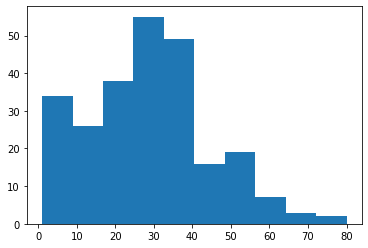

median age = 30.000


In [106]:
# fix age
import numpy as np
flat_author_attribute_data = flat_author_attribute_data.assign(**{
    'age' : flat_author_attribute_data.loc[:, 'age'].apply(lambda x: x if type(x) is float and np.isnan(x) else int(x))
})
max_age = 100
flat_author_attribute_data = flat_author_attribute_data[flat_author_attribute_data.loc[:, 'age'].apply(lambda x: np.isnan(x) or x <= max_age)]
## plot age distribution
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
age_vals = flat_author_attribute_data.loc[:, 'age'].dropna().astype(int)
plt.hist(age_vals)
plt.show()
print(f'median age = {age_vals.median():.3f}')

In [97]:
## fix location => geolocate!!
from geocoder import osm
unique_locations = flat_author_attribute_data.loc[:, 'location'].unique()
unique_location_geo_data = list(tqdm(map(lambda x: osm(x), unique_locations), total=len(unique_locations)))
unique_location_geo_data = list(map(lambda x: x.json()))
unique_location_geo_data_df = list(map(lambda x: x[0].json if len(x) > 0 else None, unique_location_geo_data))
[x.update({'location' : y}) for x,y in zip(unique_location_geo_data_df, unique_locations) if x is not None]
unique_location_geo_data_df = list(filter(lambda x: x is not None, unique_location_geo_data_df))
unique_location_geo_data_df = pd.DataFrame(unique_location_geo_data_df)#.assign(**{'location' : unique_locations})
unique_location_geo_data_df = unique_location_geo_data_df.loc[:, ['location', 'accuracy', 'country_code', 'state']]
# drop low-confidence scores
loc_conf_cutoff = 0.5
unique_location_geo_data_df = unique_location_geo_data_df[unique_location_geo_data_df.loc[:, 'accuracy'] >= loc_conf_cutoff]
# remove nan vals
unique_location_geo_data_df = unique_location_geo_data_df[unique_location_geo_data_df.loc[:, 'location'].apply(lambda x: type(x) is str)]
display(unique_location_geo_data_df.head(20))
display(unique_location_geo_data_df.loc[:, 'country_code'].value_counts().head(20))
display(unique_location_geo_data_df.loc[:, 'state'].value_counts().head(20))

,location,accuracy,country_code,state
2,Denmark,0.806806,dk,NaN
3,Kansas,0.826542,us,Kansas
4,saudi arabia,0.735263,sa,NaN
5,Germany,0.889681,de,NaN
6,Sweden,0.841632,se,NaN
7,Italy,0.883102,it,NaN
8,Atlanta,0.800803,us,Georgia
9,California,0.922136,us,California
10,Canada,0.976126,ca,NaN
11,Baltimore,0.765295,us,Maryland


us    259
gb     31
ca     29
cn     10
au     10
it      9
mx      6
nl      6
de      6
co      5
jp      5
in      4
es      4
fr      4
ch      4
th      3
kr      3
br      3
be      3
ar      3
Name: country_code, dtype: int64

California          32
Texas               25
England             21
New York            17
Florida             11
Illinois            11
Washington           9
Ohio                 8
Pennsylvania         8
Ontario              7
British Columbia     6
Virginia             6
Michigan             6
North Dakota         5
Wisconsin            5
North Carolina       5
Québec               5
Massachusetts        5
South Carolina       5
Oregon               5
Name: state, dtype: int64

This is not great!! But we have to do something with it.

In [99]:
## normalize all the demographics
# gender
gender_norm_lookup = {
    'man' : 'M',
    'male' : 'M',
    'woman' : 'F',
    'female' : 'F',
}
flat_author_attribute_data = flat_author_attribute_data.assign(**{
    'norm_gender' : flat_author_attribute_data.loc[:, 'gender'].apply(gender_norm_lookup.get)
})
# age
age_cutoff = 30
flat_author_attribute_data = flat_author_attribute_data.assign(**{
    'norm_age' : flat_author_attribute_data.loc[:, 'age'].apply(lambda x: x if np.isnan(x) else f'{age_cutoff}+' if x >= age_cutoff else f'<{age_cutoff}')
})
# location
location_country_lookup = dict(zip(unique_location_geo_data_df.loc[:, 'location'].values, 
                                   unique_location_geo_data_df.loc[:, 'country_code'].values))
flat_author_attribute_data = flat_author_attribute_data.assign(**{
    'norm_location' : flat_author_attribute_data.loc[:, 'location'].apply(location_country_lookup.get)
})
# simplify US vs. non-US
flat_author_attribute_data = flat_author_attribute_data.assign(**{
    'norm_location' : flat_author_attribute_data.loc[:, 'norm_location'].apply(lambda x: 'US' if x=='us' else 'non_US' if type(x) is str else None)
})
## show all distributions
demo_vars = ['norm_gender', 'norm_age', 'norm_location']
for demo_var_i in demo_vars:
    print(f'demo = {demo_var_i}')
    display(flat_author_attribute_data.loc[:, demo_var_i].value_counts())

demo = norm_gender


M    972
F    323
Name: norm_gender, dtype: int64

demo = norm_age


30+    129
<30    120
Name: norm_age, dtype: int64

demo = norm_location


US        1324
non_US     927
Name: norm_location, dtype: int64

Let's merge with the full question data and see if we can differentiate the groups based on questions.

In [110]:
valid_submission_question_data = pd.read_csv('science_submission_question_data.gz', sep='\t', compression='gzip')
valid_submission_question_data = pd.merge(valid_submission_question_data,
                                          flat_author_attribute_data.rename(columns={'author' : 'author_comment'}).loc[:, ['author_comment',]+demo_vars],
                                          on='author_comment', how='inner')
print(valid_submission_question_data.shape[0])
for demo_var_i in demo_vars:
    print(f'demo = {demo_var_i}')
    display(valid_submission_question_data.loc[:, demo_var_i].value_counts())

5095
demo = norm_gender


M    1613
F     513
Name: norm_gender, dtype: int64

demo = norm_age


<30    177
30+    173
Name: norm_age, dtype: int64

demo = norm_location


US        2019
non_US    1359
Name: norm_location, dtype: int64

This is less terrible than I thought. Let's look for some differences in question asking!!

In [117]:
from importlib import reload
import twitter_data_helpers
reload(twitter_data_helpers)
from twitter_data_helpers import compute_log_odds
text_var = 'reply_question'
top_k_words = 20
for demo_var_i in demo_vars:
    data_i = valid_submission_question_data.dropna(subset=[demo_var_i])
    (val_1_i, val_2_i), word_ratio_i = compute_log_odds(data_i, text_var, demo_var_i)
    print(f'demo = {demo_var_i}')
    print(f'top words for val = {val_1_i}')
    display(word_ratio_i.head(top_k_words))
    print(f'top words for val = {val_2_i}')
    display(word_ratio_i.sort_values(ascending=True).head(top_k_words))

demo = norm_gender
top words for val = M


produce       2.060049
natural       1.991056
probably      1.991056
law           1.836905
price         1.749894
away          1.749894
factor        1.749894
antibodies    1.654584
diet          1.654584
reduce        1.654584
use           1.654584
tests         1.654584
agree         1.654584
caused        1.549223
chance        1.549223
man           1.549223
plastic       1.549223
jobs          1.549223
keep          1.549223
outside       1.549223
dtype: float64

top words for val = F


fish              -2.439761
14                -2.034296
obese             -2.034296
pain              -2.034296
alone             -2.034296
institutions      -2.034296
inquisitiveness   -2.034296
proof             -2.034296
risks             -2.034296
games             -2.034296
americans         -2.034296
abstract          -2.034296
careful           -2.034296
binaural          -2.034296
beats             -2.034296
infected          -2.034296
regulation        -1.746614
reduces           -1.746614
headed            -1.746614
evaluate          -1.746614
dtype: float64

demo = norm_age
top words for val = <30


risk       1.769956
based      1.587634
lack       1.587634
..         1.587634
white      1.587634
warmer     1.587634
100        1.587634
back       1.364490
stream     1.364490
things     1.364490
virus      1.364490
number     1.364490
old        1.364490
useful     1.364490
certain    1.364490
gun        1.364490
gulf       1.364490
natural    1.364490
theory     1.364490
correct    1.364490
dtype: float64

top words for val = 30+


next         -1.967714
country      -1.631242
trying       -1.631242
help         -1.631242
please       -1.631242
everything   -1.408098
basic        -1.408098
making       -1.408098
found        -1.408098
getting      -1.408098
say          -1.408098
explain      -1.408098
happens      -1.408098
may          -1.408098
true         -1.408098
single       -1.408098
plastic      -1.408098
feel         -1.408098
seen         -1.120416
seem         -1.120416
dtype: float64

demo = norm_location
top words for val = US


support      2.379986
blood        2.138824
policy       2.138824
born         2.043514
super        1.938153
private      1.820370
gain         1.820370
play         1.820370
hair         1.820370
universe     1.820370
ocean        1.755831
state        1.755831
combat       1.686839
basis        1.686839
single       1.686839
meant        1.686839
serious      1.686839
changing     1.686839
stress       1.686839
naturally    1.686839
dtype: float64

top words for val = non_US


discrimination   -2.204982
bring            -2.204982
stereotypes      -2.050831
online           -2.050831
therapy          -2.050831
substance        -1.868509
~                -1.868509
underlying       -1.868509
unhealthy        -1.868509
authority        -1.868509
parties          -1.868509
behaviour        -1.868509
racial           -1.868509
build            -1.868509
union            -1.868509
somewhere        -1.868509
chinese          -1.868509
victim           -1.868509
1000             -1.868509
fuck             -1.868509
dtype: float64

- Gender
    - `male`: economics (`price`, `jobs`), health (`antibodies`, `diet`), male (`man`), discussion (`agree`, `expect`), causality (`produce`, `law`, `factor`, `reduce`, `caused`)
    - `female`: organizations (`americans`, `institutions`, `regulation`), health (`infected`, `obese`), caution (`proof`, `risks`, `careful`, `evaluate`), negative experience (`pain`, `alone`)
- Age
    - `<30`: theoretical (`theory`, `natural`), numeric (`100`, `number`), certainty (`certain`, `correct`, `useful`)
    - `30+`: discussion (`please`, `explain`, `say`), uncertainty (`trying`, `may`, `feel`, `seem`), simplicity (`basic`, `everything`, `single`)
- Location
    - `US`: nature (`universe`, `ocean`), body (`blood`, `born`, `hair`), conflict (`combat`, `stress`)
    - `non_US`: social problems (`discrimination`, `stereotypes`, `underlying`, `racial`, `victim`, `unhealthy`), labor (`authority`, `union`), orthography (`~`, `behaviour`)

In [144]:
## same thing but LIWC categories
import re
LIWC_data = pd.read_csv('/home/cfwelch/LIWC.2015.all', sep=',', header=None)
LIWC_data.columns = ['word', 'category']
LIWC_data = LIWC_data.assign(**{'word' : LIWC_data.loc[:, 'word'].apply(lambda x: x.replace('*', '.*').strip())})
def try_compile(x):
    try:
        return re.compile(x)
    except Exception as e:
        return None
LIWC_data = LIWC_data.assign(**{'word_matcher' : LIWC_data.loc[:, 'word'].apply(try_compile)})
LIWC_data = LIWC_data[LIWC_data.loc[:, 'word_matcher'].apply(lambda x: x is not None)]
LIWC_combined_word_patterns = LIWC_data.groupby('category').apply(lambda x: re.compile('^(' + '|'.join(x.loc[:, 'word_matcher'].apply(lambda y: y.pattern)) + ')$'))
# get rid of bad categories
LIWC_filter_categories = ['NETSPEAK']
LIWC_combined_word_patterns.drop(LIWC_filter_categories, inplace=True)
display(LIWC_combined_word_patterns.head())
print(LIWC_combined_word_patterns.loc['ACHIEV'].pattern)

category
ACHIEV         re.compile('^(abilit.*|able|accomplish.*|ace|achievable|achieve.*|achievi.*|acquir.*|acquisition.*|actualiz.*|adequa.*|advanc.*|advantag.*|ahead|ambition|ambitions|ambitious|ambitiously|ambitiousness|attain|atta)
ADJ            re.compile("^(abnormal.*|academic|active|additional|affordable|afraid|after|aggressive|agreeable|alike|alive|alone|amazing|ambitious|ancient|angrier|angriest|angry|annoying|antisocial|anxious|apparent|approachab)
ADVERB         re.compile("^(about|absolutely|actually|again|almost|already|also|anyway.*|anywhere|apparently|around|awhile|back|barely|basically|beyond|briefly|clearly|commonly|completely|constantly|continually|definitely|esp)
AFFECT         re.compile("^(abandon.*|abuse.*|abusi.*|accept|accepta.*|accepted|accepting|accepts|ache.*|aching.*|active|actively|admir.*|ador.*|advantag.*|adventur.*|advers.*|affection.*|afraid|aggravat.*|aggress|aggressed|a)
AFFILIATION    re.compile("^(accompan.*|accomplice.*|affil.*|alliance.*|allies|

^(abilit.*|able|accomplish.*|ace|achievable|achieve.*|achievi.*|acquir.*|acquisition.*|actualiz.*|adequa.*|advanc.*|advantag.*|ahead|ambition|ambitions|ambitious|ambitiously|ambitiousness|attain|attainable|attained|attaining|attainment|attains|authorit.*|award.*|beat|beaten|best|better|bonus.*|burnout.*|capab.*|celebrat.*|challeng.*|champ.*|cheat.*|climb.*|compet.*|confidence|confident|confidently|conquer.*|conscientious.*|create|created|creates|creating|creation|creations|creative|creativity|defeat.*|demot.*|determina.*|determined|diligen.*|domina.*|driven|dropout.*|earn|earned|earning|earns|efficien.*|effort.*|elit.*|emptier|emptiest|emptiness|empty|enabl.*|endeav.*|excel|excellent|excels|fail.*|finaliz.*|first|firsts|flunk.*|founded|founder.*|founding|fulfill.*|gain.*|glory|goal.*|gpa|honor.*|honour.*|ideal.*|importance|improve.*|improving|inadequa.*|incapab.*|incentive.*|incompeten.*|ineffect.*|initiat.*|irresponsible.*|lazier|laziest|lazy|lead|leader.*|leading|leads|limit.*|lose|l

In [145]:
from importlib import reload
import twitter_data_helpers
reload(twitter_data_helpers)
from twitter_data_helpers import compute_log_odds
text_var = 'reply_question'
top_k_words = 20
for demo_var_i in demo_vars:
    data_i = valid_submission_question_data.dropna(subset=[demo_var_i])
    (val_1_i, val_2_i), word_ratio_i = compute_log_odds(data_i, text_var, demo_var_i, word_categories=LIWC_combined_word_patterns)
    val_1_counts_i = word_ratio_i[word_ratio_i > 0.].head(top_k_words)
    print(f'demo = {demo_var_i}')
    print(f'top words for val = {val_1_i}')
    display(val_1_counts_i)
    val_2_counts_i = word_ratio_i[word_ratio_i < 0.].sort_values(ascending=True).head(top_k_words)
    print(f'top words for val = {val_2_i}')
    display(val_2_counts_i)

demo = norm_gender
top words for val = M


THEY           1.223712
YOU            0.792929
INGEST         0.605466
MONEY          0.465764
FOCUSFUTURE    0.340646
SPACE          0.263618
ACHIEV         0.261436
MALE           0.250262
MOTION         0.247783
NUMBER         0.244507
ASSENT         0.220409
PPRON          0.191161
WE             0.182258
QUANT          0.173889
RELATIV        0.170115
PREP           0.156940
SEE            0.155540
CAUSE          0.143676
DISCREP        0.119369
HEAR           0.114230
dtype: float64

top words for val = F


SHEHE         -1.078874
FAMILY        -0.593366
HOME          -0.422094
FILLER        -0.385726
FEEL          -0.365524
SAD           -0.331659
HEALTH        -0.306193
DIFFER        -0.303355
INTERROG      -0.283944
AFFILIATION   -0.278628
DEATH         -0.267943
NEGEMO        -0.246174
RELIG         -0.238090
IPRON         -0.226903
RISK          -0.208392
ANX           -0.168313
SEXUAL        -0.162583
AFFECT        -0.134548
LEISURE       -0.119458
ANGER         -0.105424
dtype: float64

demo = norm_age
top words for val = <30


RELIG       0.883518
FEEL        0.798360
RISK        0.506224
POSEMO      0.420179
NEGATE      0.392895
PREP        0.354674
ADVERB      0.329568
HEALTH      0.323902
INTERROG    0.259364
DISCREP     0.259364
COMPARE     0.253943
INGEST      0.236891
ANX         0.236891
NONFLU      0.218542
QUANT       0.203274
DIFFER      0.203274
CERTAIN     0.190371
ADJ         0.181932
AFFECT      0.180470
BIO         0.138874
dtype: float64

top words for val = 30+


FRIEND        -0.944609
HEAR          -0.811078
SHEHE         -0.656927
SWEAR         -0.656927
I             -0.656927
FILLER        -0.656927
LEISURE       -0.620560
MALE          -0.474606
MONEY         -0.426404
AFFILIATION   -0.320455
FOCUSPAST     -0.295137
SOCIAL        -0.257852
FEMALE        -0.251462
PPRON         -0.251462
HOME          -0.251462
IPRON         -0.251462
ANGER         -0.238217
PRONOUN       -0.233444
ACHIEV        -0.232044
FOCUSFUTURE   -0.197395
dtype: float64

demo = norm_location
top words for val = US


THEY           1.121185
WE             0.455437
FAMILY         0.355718
PPRON          0.303566
ANX            0.237684
SAD            0.221844
REWARD         0.197831
RISK           0.178854
FILLER         0.176724
FOCUSFUTURE    0.175280
HOME           0.173396
MONEY          0.172748
ASSENT         0.147736
INFORMAL       0.136064
I              0.133799
MALE           0.119737
WORK           0.107314
DISCREP        0.102000
NONFLU         0.098081
MOTION         0.075948
dtype: float64

top words for val = non_US


SHEHE         -0.670574
CONJ          -0.370916
SEXUAL        -0.360913
INTERROG      -0.287582
ANGER         -0.255961
QUANT         -0.205378
SEE           -0.189106
BODY          -0.152182
NEGATE        -0.144481
DIFFER        -0.141730
DEATH         -0.121527
BIO           -0.116229
HEALTH        -0.113288
NUMBER        -0.104582
FEMALE        -0.100029
AFFILIATION   -0.097475
CERTAIN       -0.095210
PERCEPT       -0.074700
HEAR          -0.070020
ADVERB        -0.060119
dtype: float64

- Gender
    - `male`: others (`THEY`, `YOU`), quantity (`MONEY`, `NUMBER`, `QUANT`), self (`MALE`, `WE`, `PPRON`)
    - `female`: close relations (`SHEHE`, `FAMILY`, `HOME`), emotion (`SAD`, `FEEL`, `NEGEMO`), health (`HEALTH`, `DEATH`)
- Age
    - `<30`: emotion (`POSEMO`, `FEEL`, `AFFECT`), health (`HEALTH`, `INGEST`, `BIO`), certainty (`RISK`, `COMPARE`, `CERTAIN`)
    - `30+`: social (`FRIEND`, `SHEHE`, `MALE`, `SOCIAL`), negative emotion (`NEGEMO`, `ANGER`), social institutions (`MOENY`, `AFFILIATION`), time (`FOCUSPAST`, `FOCUSFUTURE`), comfort (`LEISURE`, `HOME`)
- Location
    - `US`: social (`THEY`, `WE`, `FAMILY`, `PPRON`), negative emotion (`SAD`, `ANX`), action (`RISK`, `FOCUSFUTURE`, `WORK`, `REWARD`)
    - `non_US`: immediate social (`SHEHE`), health (`SEXUAL`, `BODY`, `BIO`, `HEALTH`, `DEATH`), quantity (`QUANT`, `NUMBER`), evidence (`INTERROG`, `SEE`, `NEGATE`, `CERTAIN`, `PERCEPT`)

In [ ]:
## TODO: taxonomy of clarification questions